In [1]:
class LinearTrans(object):
    '''
    Linear transformation.
    '''
    
    def __init__(self, input_dim, output_dim, weight_arr=None, bias_arr=None):
        '''
        Init.
        
        Args:
            input_dim:    `int` of the number of input dimension.
            output_dim:   `int` of the number of output dimension.
            weight_arr:   `np.ndarray` of weight matrix.
            bias_arr:     `np.ndarray` of bias vector.
        
        Returns:
            y.
        '''
        if weight_arr is not None:
            self.weight_arr = weight_arr
        else:
            self.weight_arr = np.random.normal(size=(input_dim, output_dim))
        
        if bias_arr is not None:
            self.bias_arr = bias_arr
        else:
            self.bias_arr = np.zeros(output_dim)
    
    def forward(self, observed_arr):
        '''
        Forawrd.
        
        Args:
            observed_arr:     `np.ndarray` of observed data points.
        
        Returns:
            `np.ndarray`.
        '''
        self.__observed_arr = observed_arr
        output_arr = np.dot(observed_arr, self.weight_arr) + self.bias_arr
        return output_arr

    def backward(self, delta_arr):
        '''
        Backward.
        
        Args:
            delta_arr:    `np.ndarray` of delta.
        
        Returns:
            `np.ndarray` of delta.
        '''
        output_delta_arr = np.dot(delta_arr, self.weight_arr.T)
        self.delta_weight_arr = np.dot(self.__observed_arr.T, delta_arr)
        self.delta_bias_arr = np.sum(delta_arr, axis=0)
        return output_delta_arr

In [2]:
class Sigmoid(object):
    '''
    Sigmoid function.
    '''
    
    def __init__(self):
        ''' Init. '''
        self.output_arr = None
    
    def forward(self, observed_arr):
        '''
        Forawrd.
        
        Args:
            observed_arr:     `np.ndarray` of observed data points.
        
        Returns:
            `np.ndarray`.
        '''
        self.output_arr = 1 / (1 + np.exp(-observed_arr))
        return self.output_arr

    def backward(self, delta_arr):
        '''
        Backward.
        
        Args:
            delta_arr:    `np.ndarray` of delta.
        
        Returns:
            `np.ndarray` of delta.
        '''
        output_delta_arr = delta_arr * (1 - delta_arr) * self.output_arr
        return output_delta_arr

In [3]:
class MSE(object):
    ''' MSE.'''
    
    def __init__(self, ax=0):
        ''' Init.'''
        self.loss_arr = None
        self.y = None
        self.t = None
        self.__ax = ax
    
    def forward(self, pred_arr, real_arr):
        '''
        Forawrd.
        
        Args:
            pred_arr:         `np.ndarray` of predicted data.
            real_arr:         `np.ndarray` of real data.
        
        Returns:
            `np.ndarray`.
        '''
        self.loss_arr = (np.square(pred_arr - real_arr)).mean(axis=self.__ax)
        self.pred_arr = pred_arr
        self.real_arr = real_arr
        return self.loss_arr

    def backward(self, delta_arr=1):
        '''
        Backward.
        
        Args:
            delta_arr:    `np.ndarray` of delta.
        
        Returns:
            `np.ndarray` of delta.
        '''
        batch_size = self.pred_arr.shape[0]
        output_delta_arr = delta_arr * (self.pred_arr - self.real_arr) / batch_size
        return output_delta_arr


In [4]:
class NeuralNetworks(object):
    '''
    Neural Networks.
    '''
    
    def __init__(
        self, 
        input_dim, 
        hidden_dim_list, 
        output_dim, 
        loss,
        optimizer,
        net_dict_list=None
    ):
        '''
        Init.
        
        Args:
            input_dim:           `int` of the number of dimension of observed data points.
            hidden_dim_list:     `list` of `int` of the number of dimension in hidden layers.
            output_dim:          `int` of the number of dimension in output layer.
            loss:                 Loss function.
            optimizer:            optimizer
            net_dict_list:        `list` of `dict` of parameters.
        '''
        if net_dict_list is None:
            self.net_dict_list = [
                {
                    "linear_trans": LinearTrans(input_dim=input_dim, output_dim=hidden_dim_list[0]),
                    "activation": Sigmoid(),
                }
            ]
            for i in range(1, len(hidden_dim_list)):
                before_dim = hidden_dim_list[i - 1]
                after_dim = hidden_dim_list[i]
                self.net_dict_list.append(
                    {
                        "linear_trans": LinearTrans(input_dim=before_dim, output_dim=after_dim),
                        "activation": Sigmoid()
                    }
                )

            self.net_dict_list.append(
                {
                    "linear_trans": LinearTrans(input_dim=hidden_dim_list[-1], output_dim=output_dim),
                    "activation": Sigmoid(),
                }
            )
        else:
            self.net_dict_list = net_dict_list

        self.__loss = loss
        self.__optimizer = optimizer

    def forward(self, observed_arr):
        '''
        Forawrd.
        
        Args:
            observed_arr:     `np.ndarray` of observed data points.
        
        Returns:
            `np.ndarray`.
        '''
        self.__observed_arr = observed_arr
        for i in range(len(self.net_dict_list)):
            # Forward.
            observed_arr = self.net_dict_list[i]["linear_trans"].forward(observed_arr)
            # Activation.
            observed_arr = self.net_dict_list[i]["activation"].forward(observed_arr)

        return observed_arr

    def compute_loss(self, pred_arr, real_arr):
        loss = self.__loss.forward(pred_arr, real_arr)
        return np.mean(loss)
    
    def backward(self):
        delta_arr = self.__loss.backward(delta_arr=1)
        net_dict_list = self.net_dict_list[::-1]
        for i in range(len(net_dict_list)):
            delta_arr = net_dict_list[i]["activation"].backward(delta_arr)
            delta_arr = net_dict_list[i]["linear_trans"].backward(delta_arr)
        
        self.net_dict_list = net_dict_list[::-1]

        grads_dict = {}
        params_dict = {}
        for i in range(len(self.net_dict_list)):
            grads_dict.setdefault(
                "weight_" + str(i),
                self.net_dict_list[i]["linear_trans"].delta_weight_arr
            )
            grads_dict.setdefault(
                "bias_" + str(i),
                self.net_dict_list[i]["linear_trans"].delta_bias_arr
            )
            params_dict.setdefault(
                "weight_" + str(i),
                self.net_dict_list[i]["linear_trans"].weight_arr
            )
            params_dict.setdefault(
                "bias_" + str(i),
                self.net_dict_list[i]["linear_trans"].bias_arr
            )

        params_dict = self.__optimizer.update(params_dict=params_dict, grads_dict=grads_dict)
        for i in range(len(self.net_dict_list)):
            self.net_dict_list[i]["linear_trans"].weight_arr = params_dict["weight_" + str(i)]
            self.net_dict_list[i]["linear_trans"].bias_arr = params_dict["bias_" + str(i)]


In [5]:
import numpy as np

class SGD(object):
    '''
    SGD.
    '''
    
    def __init__(self, learning_rate=0.01):
        '''
        Init.
        
        Args:
            learning_rate:    Learning rate.
        '''
        self.__learning_rate = learning_rate
    
    def update(self, params_dict, grads_dict):
        '''
        Update parameters.
        
        Args:
            params_dict:    `dict` of `np,ndarray` of parameters.
            grads_dict:     `dict` of `np.ndarray` of grads.
        '''
        for key in params_dict.keys():
            params_dict[key] -= self.__learning_rate * grads_dict[key]
        
        return params_dict

In [6]:
nn = NeuralNetworks(
    input_dim=10, 
    hidden_dim_list=[5, 5], 
    output_dim=10, 
    loss=MSE(),
    optimizer=SGD(learning_rate=0.001)
)

In [7]:
batch_size = 20
iter_n = 1000
dataset_arr = np.random.normal(loc=0.5, scale=0.001, size=(1000, 10))
real_dataset_arr = dataset_arr * np.random.normal(loc=0.5, scale=0.001, size=(1000, 10))

loss_list = []
for _ in range(iter_n):
    key_arr = np.random.randint(low=0, high=dataset_arr.shape[0], size=batch_size)
    observed_arr = dataset_arr[key_arr]
    real_arr = real_dataset_arr[key_arr]
    pred_arr = nn.forward(observed_arr)
    loss = nn.compute_loss(real_arr=real_arr, pred_arr=pred_arr)
    nn.backward()
    loss_list.append(loss)
    

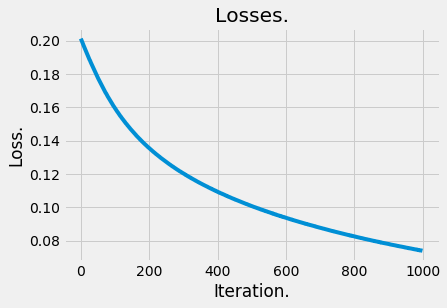

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

plt.xlabel("Iteration.")
plt.ylabel("Loss.")
plt.title("Losses.")
plt.plot(loss_list)
plt.show()

In [9]:
import numpy as np

class MomentumSGD(object):
    '''
    SGD with momentum.
    '''
    
    def __init__(self, learning_rate=0.01, momentum=0.9):
        '''
        Init.
        
        Args:
            learning_rate:    Learning rate.
            momentum:         Momentum.
        '''
        self.__learning_rate = learning_rate
        self.__momentum = momentum
        self.__value_dict = None
    
    def update(self, params_dict, grads_dict):
        '''
        Update parameters.
        
        Args:
            params_dict:    `dict` of `np,ndarray` of parameters.
            grads_dict:     `dict` of `np.ndarray` of grads.
        '''
        if self.__value_dict is None:
            self.__value_dict = {}
            for key, arr in params_dict.items():
                self.__value_dict.setdefault(key, np.zeros_like(arr))

        for key in params_dict.keys():
            self.__value_dict[key] = self.__momentum * self.__value_dict[key] - self.__learning_rate * grads_dict[key]
            params_dict[key] += self.__value_dict[key]
        
        return params_dict

In [10]:
nn = NeuralNetworks(
    input_dim=10, 
    hidden_dim_list=[5, 5], 
    output_dim=10, 
    loss=MSE(),
    optimizer=MomentumSGD(learning_rate=0.001, momentum=0.9)
)

In [11]:
batch_size = 20
iter_n = 1000
dataset_arr = np.random.normal(loc=0.5, scale=0.001, size=(1000, 10))
real_dataset_arr = dataset_arr * np.random.normal(loc=0.5, scale=0.001, size=(1000, 10))

loss_list = []
for _ in range(iter_n):
    key_arr = np.random.randint(low=0, high=dataset_arr.shape[0], size=batch_size)
    observed_arr = dataset_arr[key_arr]
    real_arr = real_dataset_arr[key_arr]
    pred_arr = nn.forward(observed_arr)
    loss = nn.compute_loss(real_arr=real_arr, pred_arr=pred_arr)
    nn.backward()
    loss_list.append(loss)


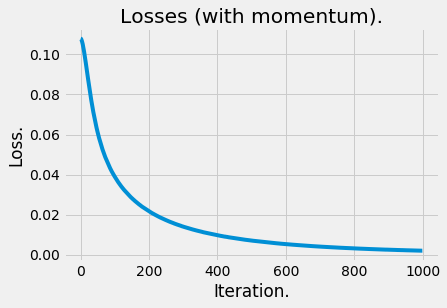

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

plt.xlabel("Iteration.")
plt.ylabel("Loss.")
plt.title("Losses (with momentum).")
plt.plot(loss_list)
plt.show()